In [ ]:
#importa as bibliotecas necessárias
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time
import statistics as st

In [ ]:
#carrega dados
num_agentes = int(np.genfromtxt('m.csv', delimiter=","))
num_tarefas = int(np.genfromtxt('n.csv', delimiter=","))
mat_recurso_agente = np.genfromtxt('a.csv', delimiter=',')
mat_custo_tarefa = np.genfromtxt('c.csv', delimiter=',')
vet_capacidade = np.genfromtxt('b.csv', delimiter=',')

In [ ]:
#restrição de capacidade dos agentes
#return 1 -> restrição quebrada
def restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao):
    agente = 0
    quebra_total = 0

    while (agente < num_agentes):
      esforco = 0
      tarefa = 0
      while (tarefa < num_tarefas):
          esforco = esforco + mat_solucao[agente,tarefa]*mat_recurso_agente[agente,tarefa]
          tarefa += 1
      if (esforco > vet_capacidade[agente]):
          quebra_total = quebra_total + (esforco - vet_capacidade[agente])

      agente += 1
    return quebra_total

In [ ]:
#função objetivo fc()
def fobjc(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao, epsilon):
    custo = np.sum(mat_solucao * mat_custo_tarefa)
    custo = custo + restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) * 10
    
    restricao_fe = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao)

    if (restricao_fe > epsilon):
        custo = custo + (restricao_fe - epsilon) * 10
    return custo

In [ ]:
#função objetivo fe()
def fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao):
    maior_esforco = 0
    menor_esforco = 10000
    agente = 0
    
    while (agente < num_agentes):
      esforco = 0
      tarefa = 0
      while (tarefa < num_tarefas ):
        esforco = esforco + mat_solucao[agente,tarefa]*mat_recurso_agente[agente,tarefa]
        tarefa += 1
      if (esforco > maior_esforco):
        maior_esforco = esforco.copy()
      if (esforco < menor_esforco):
        menor_esforco = esforco.copy()
      agente += 1
    
    diferenca = maior_esforco - menor_esforco

    diferenca = diferenca + restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao) * 3

    return diferenca

In [ ]:
#gera uma solucação inicial factível para o problema
def solucao_inicial(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade):
    mat_solucao_inicial = np.zeros((num_agentes, num_tarefas), int)
    vet_tarefa_concluida = np.zeros(num_tarefas)
    agente = 0
    while (agente < num_agentes):
        esforco = 0
        tarefa = 0
        while (tarefa < num_tarefas):
            esforco = esforco + mat_recurso_agente[agente,tarefa]
            if (vet_tarefa_concluida[tarefa] == 0 and esforco <= vet_capacidade[agente]):
                vet_tarefa_concluida[tarefa] = 1
                mat_solucao_inicial[agente][tarefa] = 1
            else:
                esforco = esforco - mat_recurso_agente[agente,tarefa]
            tarefa+=1
        agente+=1
    
    return mat_solucao_inicial

In [ ]:
#define as cinco estruturas de vizinhança
def vizinhanca(num_agentes, num_tarefas, mat_solucao, vizinho, mat_recurso_agente):

    #Vizinhança Task Move
    if (vizinho == 1):
        tarefa = random.randint(0, num_tarefas-1)
        for i in range(num_agentes):
          if mat_solucao[i,tarefa] == 1:
            pos = i
            break
        agente = random.choice([lista for lista in range(num_agentes) if lista != pos])
        mat_solucao[:,tarefa] = 0
        mat_solucao[agente,tarefa] = 1

    #Vizinhança Swap
    elif (vizinho == 2):
        tarefa1 = random.randint(0, num_tarefas-1)
        tarefa2 = 0
        for i in range(num_agentes):
          if mat_solucao[i,tarefa1] == 1:
            agente1 = i
            break
        agente2 = random.choice([lista for lista in range(num_agentes) if lista != agente1])
        tarefa_shuffle = list(range(num_tarefas))
        random.shuffle(tarefa_shuffle)
        for i in tarefa_shuffle:
          if mat_solucao[agente2,i] == 1:
            tarefa2 = i
            break
        mat_solucao[:,tarefa1] = 0
        mat_solucao[:,tarefa2] = 0
        mat_solucao[agente2,tarefa1] = 1
        mat_solucao[agente1,tarefa2] = 1
              
    #seleciona aleatoriamente duas tarefas e troca seus agentes
    elif (vizinho == 3):
        tarefa1 = random.randint(0, num_tarefas-1)
        tarefa2 = random.randint(0, num_tarefas-1)
        aux = np.copy(mat_solucao[:, tarefa1])
        mat_solucao[:,tarefa1] = np.copy(mat_solucao[:, tarefa2])
        mat_solucao[:,tarefa2] = np.copy(aux)
      
    #troca todas as colunas com a coluna a sua direita
    elif (vizinho == 4): 
        coluna = 0
        while (coluna < num_tarefas - 1):
            linha = 0
            while (linha < num_agentes):
                aux = np.copy(mat_solucao[linha,coluna])
                mat_solucao[linha,coluna] = np.copy(mat_solucao[linha,coluna+1])
                mat_solucao[linha,coluna+1] = np.copy(aux)
                linha+=1
            coluna+=2           

    #seleciona aleatoriamente duas linhas e as troca 
    elif (vizinho == 5):
        agente1 = random.randint(0, num_agentes-1)
        agente2 = random.randint(0, num_agentes-1)
        aux = np.copy(mat_solucao[agente1, :])
        mat_solucao[agente1,:] = np.copy(mat_solucao[agente2, :])
        mat_solucao[agente2,:] = np.copy(aux)
    
    return mat_solucao

In [ ]:
def SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, func, epsilon = 0):
    vizinho = 1
    #temperatura inicial
    tk = 100
    #contador de estágios estagnados
    estagios_estagnados = 0

    #contador de avaliações da função f()
    nfe = 0
    
    #encontrando a solução inicial e a definindo como melhor solução
    mat_solucao_inicial = solucao_inicial(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade).copy()
    mat_solucao_atual = np.copy(mat_solucao_inicial)
    mat_melhor_solucao = np.copy(mat_solucao_inicial)

    if (func == 'c'):
        custo_atual = fobjc(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_melhor_solucao, epsilon).copy()
    elif (func == 'e'):
        custo_atual = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_inicial).copy()       
        
    melhor_custo = custo_atual.copy()
    vet_custos = []
    vet_custos.append(custo_atual)

    vet_factivel = []
    vet_factivel.append(custo_atual) 

    while (estagios_estagnados <= 10 and nfe < 10000):

        num_aceites = 0
        num_tentativas = 0
        na = 1

        fevalin = melhor_custo.copy()


        while (num_aceites < 12*num_tarefas and num_tentativas < 100*num_tarefas):

            if (vizinho > 5):
                vizinho = 1
            mat_solucao_prox = vizinhanca(num_agentes, num_tarefas, mat_solucao_atual, vizinho, mat_recurso_agente)

            if (func == 'c'):
                custo_prox = fobjc(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_prox, epsilon)
            elif (func == 'e'):
                custo_prox = fobje(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, mat_solucao_prox)

            if (restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao_prox) == 0):
                vet_factivel.append(custo_prox)

            nfe+=1
            
            delta_e = custo_prox - custo_atual
            
            aleatorio = random.uniform(0,1)

            if (delta_e <= 0 or (aleatorio <= math.exp(-delta_e/tk))):

                mat_solucao_atual = np.copy(mat_solucao_prox)

                custo_atual = custo_prox.copy()

                num_aceites+=1
                
                if (custo_atual < melhor_custo and restricao_capacidade(num_agentes, num_tarefas, mat_recurso_agente, vet_capacidade, mat_solucao_atual) == 0):
                    vizinho = 1
                    mat_melhor_solucao = np.copy(mat_solucao_atual)
                    melhor_custo = custo_atual.copy()
                else:
                    vizinho += 1
            else:
                vizinho += 1
            
            num_tentativas+=1

            #armazena o custo corrente
            vet_custos.append(custo_atual)
            
        #atualiza a temperatura
        tk = 0.5*tk
        if (tk < 20):
          tk = 100
        
        #avalia critério de estagnação
        if (melhor_custo < fevalin):
            estagios_estagnados = 0
        else:
            estagios_estagnados += 1
        
    if (func == 'c'):
        return mat_melhor_solucao, melhor_custo, vet_custos, vet_factivel

    elif (func == 'e'):
        epsilon = st.mean(vet_custos)
        return epsilon

In [ ]:
def epsilon_restrito(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade):
    func = 'e'
    epsilon = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, func)
    vetor_epsilon = []
    vetor_epsilon.append(epsilon)
    while (len(vetor_epsilon) < 5):
        epsilon = epsilon * 0.9
        vetor_epsilon.append(epsilon)
    
    func = 'c'
    i = 0

    factiveis = []
    while (i < 5):
        epsilon = vetor_epsilon[i]
        mat_melhor_solucao, melhor_custo, vet_custos, vet_factivel = SA(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade, func, epsilon)
        factiveis.append(vet_factivel)
        i+=1
    
    vet_pareto_otima = []
    for sublist in factiveis:
        for val in sublist:
            vet_pareto_otima.append(val)
    
    tam_custos = len(vet_custos)
    tam_pareto = len(vet_pareto_otima)
    x = np.linspace(0, tam_custos, tam_pareto) 
    
    plt.plot(vet_custos)
    plt.plot(x, vet_pareto_otima)
    plt.ylabel('Custo')
    plt.xlabel('Iteração')
    plt.show()

    return vet_custos

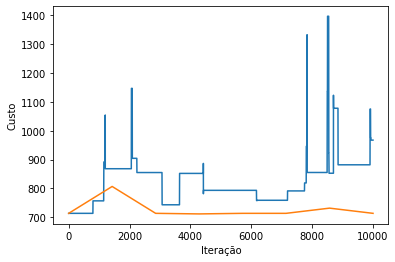

Melhor custo: 714.0
Menor custo: 714.0
Maior custo: 1396.1324098502496
Média: 822.869063062905
Desvio padrão: 78.25729703645382
Tempo de execução: 94.1515097618103


In [ ]:
inicio = time.time()
vet_custos = epsilon_restrito(num_agentes, num_tarefas, mat_recurso_agente, mat_custo_tarefa, vet_capacidade)
fim = time.time()

print('Melhor custo:', melhor_custo)
print('Menor custo:', min(vet_custos))
print('Maior custo:', max(vet_custos))
print('Média:', st.mean(vet_custos))
print('Desvio padrão:', st.pstdev(vet_custos))
print('Tempo de execução:', fim - inicio)